The goal of this notebook is to test out how downsampling system matrices affects MPC performance

In [1]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd

 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
import opinf
config = dotenv_values(".env")
from util import *
from scipy import signal

from sympy import Matrix, init_printing
init_printing()

In [2]:
# Hyperparameters for simulation
n = 4 # dimension of full order state
l = 2 # dimension of input vector
m = 1 # dimension of output vector

n_timesteps = 500 # number of timesteps to simulate
dt = 0.01 # timestep size




In [3]:
# Make random linear system matrices with some sparsity where entries are drawn from normal distribution
A = np.random.rand(n,n) - 1
# A[np.abs(A<0.4)] = 0
# A = A - np.diag(np.sum(A, axis=0))
B = np.random.rand(n, l)
# Make C a pass-through matrix
# C=np.eye(m,n)

C = np.random.rand(m, n)
D = np.zeros((m, l))



In [4]:
# Make discrete time linear system
dMats = signal.cont2discrete((A, B, C, D), dt=dt)
# sys = signal.dlti(dMats[0], dMats[1], dMats[2], dMats[3], dt=dt)
A_d = dMats[0] # np.array([0.5]) 
B_d = dMats[1] # np.array([1]) 
C_d = dMats[2] # np.array([1]) 
D_d = dMats[3] # np.array([0]) 

In [5]:
# Downsample system assuming constant input
N_ds = 50 # Downsample factor
A_ds = np.linalg.matrix_power(A_d, N_ds)
A_ds_ps = np.eye(n)
for i in range(1,N_ds):
    A_ds_ps += np.linalg.matrix_power(A_d, i)
B_ds = np.matmul(A_ds_ps, B_d)
C_ds = C_d
D_ds = D_d

    

In [6]:
print("A: ", A)
print("A_d: ", A_d)
print("A_ds: ", A_ds)
print("A_ds_ps: ", A_ds_ps)


A:  [[-0.46709366 -0.78455569 -0.44207212 -0.49198735]
 [-0.09802205 -0.89834765 -0.05531634 -0.06354823]
 [-0.65737142 -0.00278142 -0.31130154 -0.50411577]
 [-0.37562876 -0.85475932 -0.37406902 -0.5220311 ]]
A_d:  [[ 9.95367394e-01 -7.77133657e-03 -4.39229102e-03 -4.88209831e-03]
 [-9.70571942e-04  9.91063255e-01 -5.46502608e-04 -6.27215015e-04]
 [-6.53882693e-03  1.93474288e-05  9.96915661e-01 -5.00415315e-03]
 [-3.72140595e-03 -8.47251803e-03 -3.71457308e-03  9.94814522e-01]]
A_ds:  [[ 0.84252697 -0.25025182 -0.16496103 -0.17118895]
 [-0.03047985  0.64793268 -0.01504359 -0.01626512]
 [-0.25978766  0.08287635  0.90210528 -0.17799375]
 [-0.1189387  -0.28186404 -0.13560358  0.80793211]]
A_ds_ps:  [[45.58330568 -7.14982658 -4.45157573 -4.74254936]
 [-0.87999304 40.64158525 -0.45843047 -0.50826984]
 [-6.86891884  1.45413961 47.17357267 -4.90742575]
 [-3.41808829 -7.95811312 -3.69800378 44.7889563 ]]


In [7]:
# Set initial condition and input
x0 = np.zeros((n, 1))
u_ds = np.random.rand(l, n_timesteps//N_ds) - 0.5
# generate u by having N_ds timesteps of the same input from u_ds
u = np.zeros((l, n_timesteps))
for i in range(n_timesteps):
    u[:,i] = u_ds[:,i//N_ds] 
# u = np.ones((l, n_timesteps))
# u = np.cumsum(u, axis=1)
#np.sin(np.linspace(0, 10, n_timesteps))

In [8]:
print("u_ds: ", u_ds[:,:5])
print("u: ", u[:,:6*N_ds])

u_ds:  [[ 0.17627345 -0.118818    0.39362428 -0.32774393  0.08715845]
 [ 0.02663281 -0.14193653  0.00253342  0.11509102 -0.03131571]]
u:  [[ 0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345  0.17627345  0.17627345  0.17627345  0.17627345
   0.17627345  0.17627345 -0.118818   -0.118818   -0.118818   -0.118818
  -0.118818   -0.118818   -0.118818   -0.118818   -0.118818   -0.118818
  -0.118818   -0.118818   -0.118818   -0.118818   -0.118818   -0.118818
  -0.118818   -0.118818   -0.118818   -0.118818   -0.1

In [9]:
# Simulate discrete time linear system
# Initialize array to hold state data and output data
# Original state and output
X = np.zeros((n, n_timesteps))
X[:, [0]] = x0
Y = np.zeros((m, n_timesteps))
Y[:, [0]] = np.dot(C_d, x0)
# Downsampled state and output
X_ds = np.zeros((n, n_timesteps//N_ds))
X_ds[:, [0]] = x0
Y_ds = np.zeros((m, n_timesteps//N_ds))
Y_ds[:, [0]] = np.dot(C_d, x0)

In [10]:
# Simulate original system 
for i in range(n_timesteps-1):
    X[:, [i+1]] = np.dot(A_d, X[:, [i]]) + np.dot(B_d, u[:, [i]])
    Y[:, [i+1]] = np.dot(C_d, X[:, [i]]) + np.dot(D_d, u[:, [i]])
# Simulate downsampled system
n_timesteps_ds = int(n_timesteps//N_ds)
for i in range(n_timesteps_ds-1):
    X_ds[:, [i+1]] = np.dot(A_ds, X_ds[:, [i]]) + np.dot(B_ds, u_ds[:, [i]])
    Y_ds[:, [i+1]] = np.dot(C_ds, X_ds[:, [i]]) + np.dot(D_ds, u_ds[:, [i]])

In [11]:
n_timesteps_ds

In [12]:
N_ds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


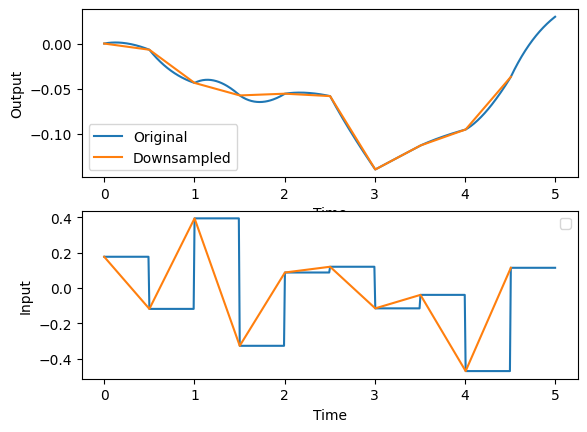

In [13]:
# Plot original and downsampled output over time on same supblot
time = np.linspace(0, n_timesteps*dt, n_timesteps)
time_ds = time[:n_timesteps:N_ds]
# time_ds = np.linspace(0, n_timesteps_ds*dt*N_ds, n_timesteps_ds)
# Plot outputs on a subplot
fig, ax = plt.subplots(2,1)
ax[0].plot(time, X[0,:], label='Original')
ax[0].plot(time_ds, X_ds[0,:], label='Downsampled')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Output')
ax[0].legend()
# Plot inputs on a subplot
ax[1].plot(time, u[0,:])
ax[1].plot(time_ds, u_ds[0,:])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Input')
ax[1].legend()


plt.show()
